<a href="https://colab.research.google.com/github/valerijakeda/valerijakeda/blob/main/Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authenticated
Database Was Succesfully Imported


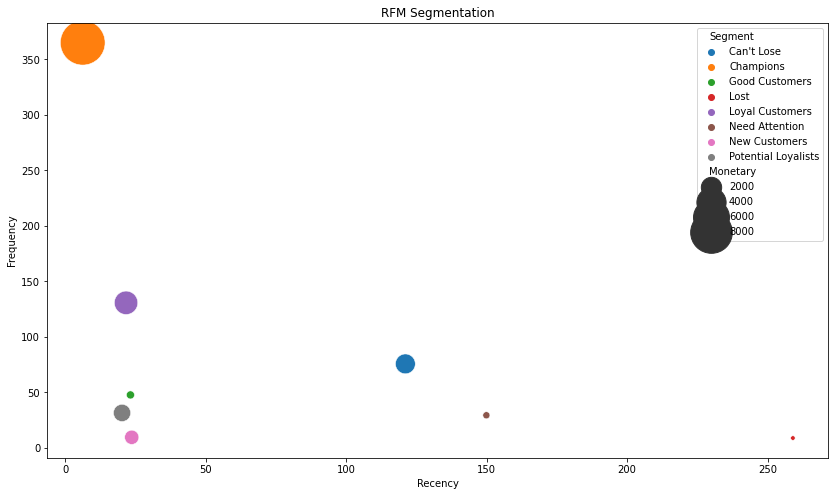

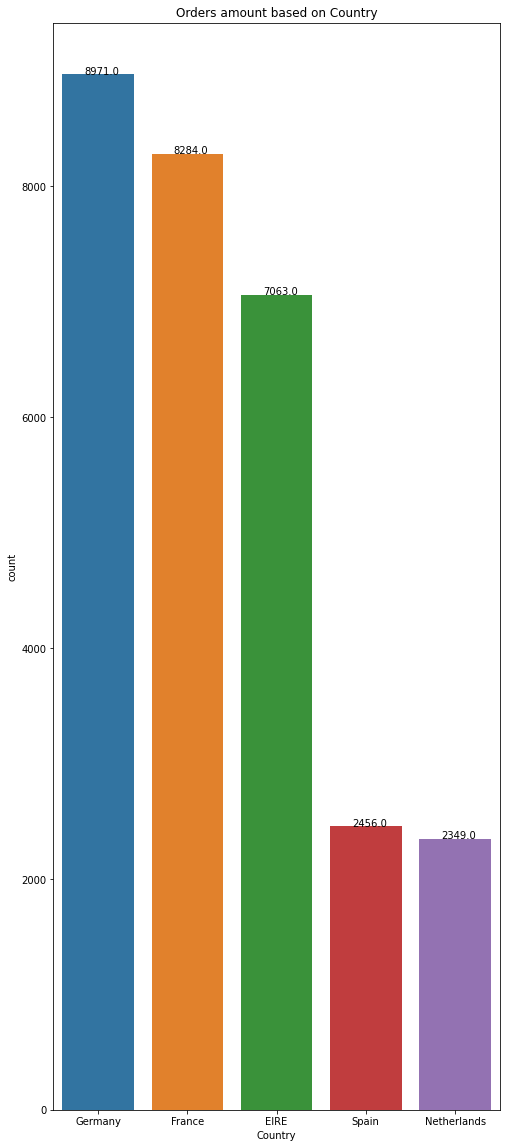

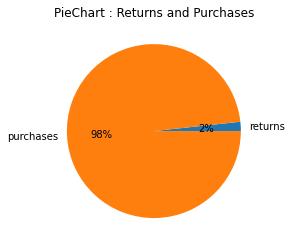

"\nwith pd.option_context('display.max_rows', None,\n                       'display.max_columns', None,\n                       'display.precision', 3,\n                       ):\n    print(rfm)\n"

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from statistics import mean 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


def import_dataframe (database_name, data_frame_index, project_id = 'tc-da-1'):
  """Function that imports a dataframe from a given database in BigQuery
  The default project_id is 'tc-da-1'
  Note: It is neccesary to give an access to your google account connected to BigQuery, where your projects are
  """
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')
  
  from google.cloud import bigquery
  client = bigquery.Client(project = project_id)
  dataset_ref = client.dataset(database_name, project = project_id)
  dataset = client.get_dataset(dataset_ref)
  tables = list(client.list_tables(dataset))
  print("Database Was Succesfully Imported")

  df = client.list_rows(tables[data_frame_index]).to_dataframe()
  
  return df

def creating_segments():
  """Function that assigns segmenting keys to a dictionary
  """
  seg_map = {}
  for key in ['311', '312', '313', '314', '411', '412', '413', '414']:
    seg_map[key] =  'New Customers'
  for key in ['111', '112']:
    seg_map[key] = 'Lost'
  for key in ['114', '113', '123', '124', '133', '134', '144', '143', '213', '214', '223', '224', '233', '234', '243', '244']:
    seg_map[key] = 'Can\'t Lose'
  for key in ['121', '122', '131', '132', '141', '142', '211', '212', '221', '222', '231', '232', '241', '242']:
    seg_map[key] = 'Need Attention'
  for key in ['321', '322','331', '332','341','342', '421', '422', '431', '432', '441', '442']:
    seg_map[key] = 'Good Customers'
  for key in ['323', '324', '423', '424']:
    seg_map[key] = 'Potential Loyalists'
  for key in ['333', '334', '343', '433', '434', '443', '344']:
    seg_map[key] = 'Loyal Customers'
  seg_map['444'] = 'Champions'
  return seg_map

def cleaning_for_rfm (df):
  """This cleaning function is designed for dataframes with particular column names:
  Columns: 'InvoiceDate', 'UnitPrice' and 'Quantity' are necessary
  """
  df = df.drop_duplicates()
  df.isnull().sum()
  df.dropna(inplace=True)
  try: 
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df = df[(df.Quantity>0) & (df.UnitPrice> 0)]
    df['Total_Price'] = df['UnitPrice']*df['Quantity']
  except: 
    print('DataFrame doesn\'t have necessary columns for this analysis')
    exit()
  try: 
    df = df[~df['StockCode'].str.contains('C')]
  except: 
    pass
  return df

def assigning_values(df, seg_map):
  """RFM analysis function (scalling from 1 to 4). 
  Note: Before using it - create a segmentation map using function creating_segments() or use your custom one but with scalling from 1 to 4 and all 3 values
  """
  rfm = df.groupby('CustomerID').agg({'InvoiceDate' : lambda day : (df['InvoiceDate'].max() - day.max()).days, 'InvoiceNo': lambda num : len(num), 'Total_Price': lambda price : price.sum()})
  column_list = ['Recency','Frequency','Monetary']
  rfm.columns = column_list
  rfm["R"] = pd.qcut(rfm["Recency"],4 ,labels = [4,3,2,1])
  rfm["F"] = pd.qcut(rfm["Frequency"],4 ,labels = [1,2,3,4])
  rfm["M"] = pd.qcut(rfm["Monetary"],4 ,labels = [1,2,3,4])
  rfm["RFM"] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm["M"].astype(str)
  rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm["M"].astype(str)
  rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
  return rfm

def plotting_rfm(rfm):
  """Function that is plotting a bubble chart for RFM analysis using Seaborn Package
  """

  fig = plt.figure(figsize = (14, 8))
  bubble_chart = sns.scatterplot(data = rfm.groupby('Segment').mean(), x = "Recency", y = "Frequency", size = "Monetary", hue = "Segment", legend = True, sizes=(20, 2000))
  bubble_chart.set(title = 'RFM Segmentation')
  plt.show()

def plotting_bar_chart(df, category, r_number1, r_number2):
  """Function that is plotting a bar chart based on category for fiven range(defaul category - Country)

  """
  invoices = dict()
  for number in df["InvoiceNo"]:
      invoices[number] = invoices.get(number, 0) + 1

  df_invoices = pd.DataFrame(invoices.items(), columns=['InvoiceNo', 'Number'])

  df_with_category = pd.merge(df_invoices,df[['InvoiceNo',category]], on = 'InvoiceNo', how = 'inner')

  fig = plt.figure(figsize = (8, 20))
  bar_chart = sns.countplot(data = df_with_category, x = category, order = df_with_category[category].value_counts().index[r_number1:r_number2])
  bar_chart.set(title = 'Orders amount based on ' + category)
  #to add values to the bars
  for p in bar_chart.patches:
    bar_chart.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
  plt.show()

def plotting_pie_chart(df, difference, labels):
  """This function fits if you have 2 different categories
  Note: the difference in InvoiceNo must be in the begining of the name
  """
  variables = [0, 0]
  for name in df['InvoiceNo']:
    if name.startswith(difference):
      variables[0] = variables[0] + 1
    else:
      variables[1] = variables[1] + 1
  
  plt.pie(variables, labels = labels, autopct='%.0f%%')
  plt.title("PieChart : Returns and Purchases")
  plt.show()

#First Step: creating RFM segments dictionary
seg_map = creating_segments() 

#Second Step: importing a dataframe from a database from my Turing College BigQuery 
df = import_dataframe('turing_data_analytics', 2) #I need rfm table which is third from the beggining

df_copy = df #creating this copy because we will need it in plotting pie chart

#Third Step: cleaning the data in dataframe before analysis
df = cleaning_for_rfm(df)

#Forfth Step: assigning RFM values to a new dataframe 
rfm = assigning_values(df, seg_map)

#Fifth Step: plotting RFM bubble chart grouped by RFM Segment
plotting_rfm(rfm)

#*Code for RFM Table
#rfm.head() 
#rfm.groupby('Segment').mean().round()

#Additional Task: plotting bar chart counting number of invoices by Country
plotting_bar_chart(df, 'Country', 1, 6)

#Additional Task: plotting pie chart comparing the amount of purchases and returns
plotting_pie_chart(df_copy, 'C', ['returns', 'purchases'])

#Additional Task: printing all clients' RFM data 
"""
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(rfm)
"""
